In [2]:
#feature coef bear in mind this is not within each fold. 
#This is the coefficients if I fit the entire model using all the data
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
import numpy as np
import os
import sys
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
import itertools
#import other python scripts for further anlaysis
import reshape
import plotFW

# Initialization of directory information:
thisDir = os.path.expanduser('~/Desktop/MSC_Alexis/analysis/')
dataDir = thisDir + 'data/mvpa_data/'
outDir = thisDir + 'output/mL/'
# Subjects and tasks
taskList=['mixed', 'motor','mem']
subList=['MSC01','MSC02','MSC03','MSC04','MSC05','MSC06','MSC07','MSC10']

def model(classifier,train_sub, train_task):
    if classifier=='SVC':
        clf=LinearSVC()
    elif classifier=='logReg':
        clf=LogisticRegression(solver = 'lbfgs')
    elif classifier=='ridge':
        clf=RidgeClassifier()
    else:
        print('Error: You didnt specify what classifier')
    taskFC=reshape.matFiles(dataDir+train_task+'/'+train_sub+'_parcel_corrmat.mat')
    restFC=reshape.matFiles(dataDir+'rest/'+train_sub+'_parcel_corrmat.mat')
    x_train, y_train=reshape.concateFC(taskFC, restFC)
    clf.fit(x_train,y_train)
    #absolute value of feature weights
    importance = np.abs(clf.coef_)
    #convert to useable form
    df=plotFW.saveFW(importance)
    df.columns = df.columns.droplevel(1)
    df.index=df.index.droplevel(1)
    df = df.where(np.triu(np.ones(df.shape),1).astype(np.bool))
    df = df.stack().reset_index()
    df.columns = ['Row','Column','Coef']

    group=df.groupby(['Row','Column']).sum()
    group.reset_index(level=[1], inplace=True)
    #get top feature combinations
    top=group.nlargest(1,'Coef')
    top['sub']=train_sub
    top['task']=train_task
    return top


In [3]:
result=pd.DataFrame()
for sub in subList:
    for task in taskList:
        tmp_df=model('ridge', sub, task)
        result = result.append(tmp_df)
result.reset_index(inplace=True)
result['Row.Column']=result['Row']+'.'+result['Column']

In [114]:
k=result['task']=='mixed'

mix=result[k]

In [129]:
mix.head()

,Row,Column,Coef,sub,task,Row.Column
0,unassign,default,0.560412,MSC01,mixed,unassign.default
3,unassign,default,0.705588,MSC02,mixed,unassign.default
6,co,sm,0.610262,MSC03,mixed,co.sm
9,unassign,default,0.661187,MSC04,mixed,unassign.default
12,default,co,0.638585,MSC05,mixed,default.co


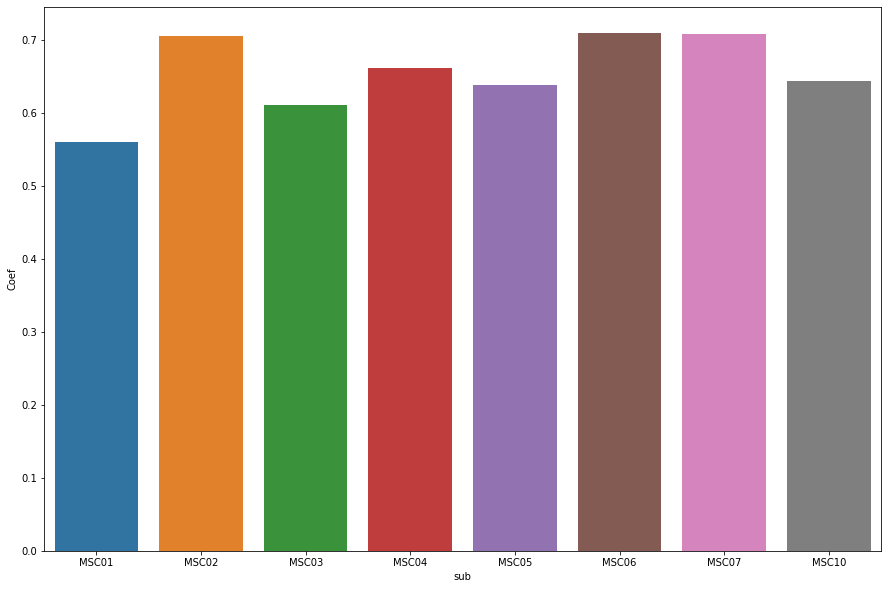

In [130]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
sns.barplot(x="sub",y='Coef', data=mix)


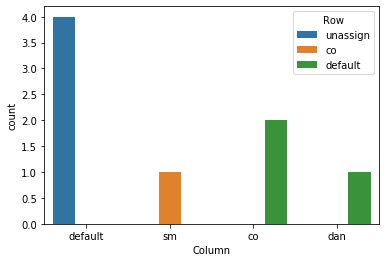

In [133]:
sns.countplot(x='Column', hue='Row', data=mix)

In [5]:
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

In [7]:
import plotly
#import plotly.plotly as py
fig = genSankey(result,cat_cols=['task','sub','Column','Row'],value_cols='Coef',title='Feature Importance')
plotly.offline.plot(fig, validate=False)


'temp-plot.html'

In [136]:
result.head()

,Row,Column,Coef,sub,task,Row.Column
0,unassign,default,0.560412,MSC01,mixed,unassign.default
1,visual,co,0.476595,MSC01,motor,visual.co
2,default,co,0.622467,MSC01,mem,default.co
3,unassign,default,0.705588,MSC02,mixed,unassign.default
4,default,dan,0.491990,MSC02,motor,default.dan
